# Using `load_masked_usgs` to load and cloud mask multiple satellite sensors

### Description
This notebook demonstrates how to use the `load_masked_usgs` function to import a time series of cloud-free observations over Africa from multiple Landsat satellites (i.e. Landsat 5, 7 and 8).
The function automatically applies cloud masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

The `load_masked_usgs` function is technically compatible with both USGS Collection 1 and Collection 2 data, however only USGS Collection 1 data is currently available to load via Digital Earth Africa.

This notebook demonstrates how to use `load_masked_usgs` to
* Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
* Optionally apply a cloud mask to the resulting data
* Filter resulting data to keep only cloud-free observations
* Optionally label resulting data with metadata indicating the satellite sensor the data came from

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [46]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import datacube.utils.rio
import sys

sys.path.append('Scripts')
from deafrica_datahandling import load_masked_usgs
from deafrica_plotting import rgb


### Connect to the datacube


In [47]:
# Connect to datacube 
dc = datacube.Datacube(app='Using_load_masked_usgs')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


## Loading multiple Landsat sensors
The `load_masked_usgs` function can be used to load a single, combined timeseries of cloud-masked data from multiple Landsat satellites. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the `dc.load` documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that the function also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load three bands of data (`red`, `green`, `blue`) from the three USGS Collection 1 products (Landsat 5, 7 and 8) by specifying:

`products=['ls5_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']`

The function always outputs the number of observations for each product, and the total number loaded.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_masked_usgs`.

In [49]:
# Load available data from all three Landsat satellites
ds = load_masked_usgs(dc=dc,
                      products=['ls5_usgs_sr_scene', 
                                'ls7_usgs_sr_scene', 
                                'ls8_usgs_sr_scene'],
                      x=(37.3975, 37.5135),
                      y=(0.7374, 0.6310),
                      time=('2017-01', '2017-06'),
                      measurements=['red', 'green', 'blue'],
                      output_crs='EPSG:32637',
                      resolution=(-30, 30),
                      group_by='solar_day')

# Print output data
print(ds)


### Query syntax
The following example demonstrates how key parameters can be stored in a `query` dictionary, to be passed as a single parameter to `load_masked_usgs`.
The `query` can then be reused in other `load_masked_usgs` calls.

In [24]:
# Create a reusable query
query = {
    'x': (37.3975, 37.5135),
    'y': (0.7374, 0.6310),
    'time': ('2017-01', '2017-06'),
    'measurements': ['red', 'green', 'blue'],
    'output_crs': 'EPSG:32637',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_masked_usgs(dc=dc, 
                      products=['ls5_usgs_sr_scene', 
                                'ls7_usgs_sr_scene', 
                                'ls8_usgs_sr_scene'], 
                      **query)

# Print output data
print(ds)


Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Applying pixel quality mask
Combining and sorting data
    Returning 11 observations 
<xarray.Dataset>
Dimensions:  (time: 11, x: 431, y: 393)
Coordinates:
  * y        (y) float64 8.152e+04 8.15e+04 8.146e+04 ... 6.98e+04 6.976e+04
  * x        (x) float64 3.217e+05 3.217e+05 3.217e+05 ... 3.345e+05 3.346e+05
  * time     (time) datetime64[ns] 2017-01-10T07:42:34.197027 ... 2017-06-19T07:42:06.960987
Data variables:
    red      (time, y, x) float32 1433.0 1445.0 1432.0 ... 1731.0 1880.0 1844.0
    green    (time, y, x) float32 980.0 976.0 970.0 ... 980.0 1028.0 1011.0
    blue     (time, y, x) float32 572.0 570.0 570.0 558.0 ... 562.0 582.0 565.0
Attributes:
    crs:      EPSG:32637


### Working with cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

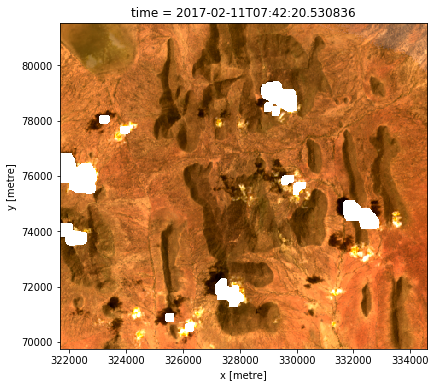

In [25]:
# Plot single observation
rgb(ds, index=2)


By default, `load_masked_usgs` applies a pixel quality mask to loaded data using Landsat's pixel quality band. For USGS Collection 1, this masks out clouds, cloud shadow and nodata by default using the following mask parameters that are applied to the `pixel_qa` band:

```
{'cloud': 'no_cloud', 
 'cloud_shadow': 'no_cloud_shadow', 
 'nodata': False}
```

For USGS Collection 2 *(currently not available)*, the following mask parameters are applied to the `quality_l2_aerosol` band: 

```
{'cloud_shadow': 'not_cloud_shadow', 
'cloud_or_cirrus': 'not_cloud_or_cirrus', 
'nodata': False}
```

> **Note:** These masking parameters can be customised using the `quality_flags` parameter

We can de-activate pixel masking completely by setting `mask_pixel_quality=False`:




Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
Combining and sorting data
    Returning 11 observations 


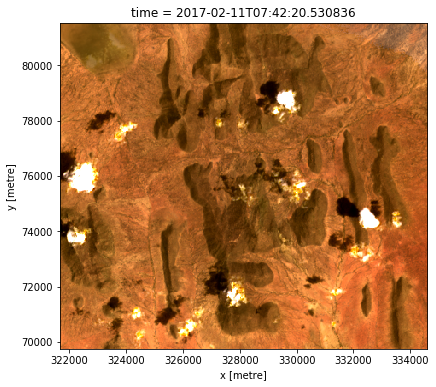

In [27]:
# Load available data with cloud masking deactivated
ds = load_masked_usgs(dc=dc, 
                      products=['ls5_usgs_sr_scene', 
                                'ls7_usgs_sr_scene', 
                                'ls8_usgs_sr_scene'], 
                      mask_pixel_quality=False, 
                      **query)

# Plot single observation
rgb(ds, index=2)


### Filtering to non-cloudy observations
In addition to masking out cloud, `load_masked_usgs` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.99` will return only observations where less than 1% of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Filtering to 5 out of 11 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 5 observations 


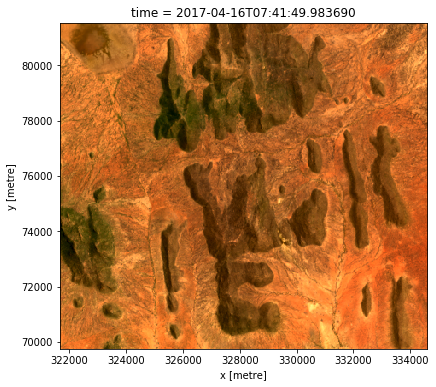

In [28]:
# Load available data filtered to 99% clear observations
ds = load_masked_usgs(dc=dc, 
                      products=['ls5_usgs_sr_scene', 
                                'ls7_usgs_sr_scene', 
                                'ls8_usgs_sr_scene'], 
                      min_gooddata=0.99, 
                      **query)

# Plot single observation
rgb(ds, index=2)


### Keeping track of sensor information
Because `load_masked_usgs` combines multiple sensors/products into a single `xarray.Dataset`, it can be important to keep track of what satellite made each observation. Setting `product_metadata=True` will add a new `product` variable to the output that labels each observation with its product name:

In [18]:
# Load available Sentinel 2 data, adding product metadata
ds = load_masked_usgs(dc=dc,
                      products=['ls5_usgs_sr_scene', 
                                'ls7_usgs_sr_scene', 
                                'ls8_usgs_sr_scene'],
                      product_metadata=True,
                      **query)

# Print output data
print(ds)


Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Applying pixel quality mask
Combining and sorting data
    Returning 11 observations 
<xarray.Dataset>
Dimensions:  (time: 11, x: 431, y: 393)
Coordinates:
  * y        (y) float64 8.152e+04 8.15e+04 8.146e+04 ... 6.98e+04 6.976e+04
  * x        (x) float64 3.217e+05 3.217e+05 3.217e+05 ... 3.345e+05 3.346e+05
  * time     (time) datetime64[ns] 2017-01-10T07:42:34.197027 ... 2017-06-19T07:42:06.960987
Data variables:
    green    (time, y, x) float32 980.0 976.0 970.0 ... 980.0 1028.0 1011.0
    product  (time) <U17 'ls8_usgs_sr_scene' ... 'ls8_usgs_sr_scene'
Attributes:
    crs:      EPSG:32637


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/issues).

**Last modified:** October 2019

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.7+130.g81bed714.dirty
